# Analisi Game Experience Questionnaire (GEQ)

Questo notebook analizza i dati raccolti mediante il Game Experience Questionnaire (GEQ), calcolando i punteggi delle varie componenti secondo le linee guida ufficiali e creando visualizzazioni utili per l'inclusione nella tesi.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from math import pi

# Configurazione del notebook
%matplotlib inline
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

## Definizione delle Componenti GEQ

Secondo le linee guida ufficiali, il GEQ è suddiviso in diverse componenti per ogni modulo. Qui sotto definiamo quali domande appartengono a ciascuna componente.

In [9]:
# Definizione delle componenti di ogni modulo
GEQ_COMPONENTS = {
    # Core Module
    'Core Module': {
        'Competenza': [2, 10, 15, 17, 21],
        'Immersione Sensoriale e Immaginativa': [3, 12, 18, 19, 27, 30],
        'Flusso': [5, 13, 25, 28, 31],
        'Tensione/Fastidio': [22, 24, 29],
        'Sfida': [11, 23, 26, 32, 33],
        'Emozioni Negative': [7, 8, 9, 16],
        'Emozioni Positive': [1, 4, 6, 14, 20]
    },
    'Post-game Module': {
        'Esperienza Positiva': [48, 52, 54, 55, 59, 63],
        'Esperienza Negativa': [49, 51, 53, 58, 61, 62],
        'Stanchezza': [57, 60],
        'Ritorno alla Realtà': [50, 56, 64]
    }
}

## Caricamento dei Dati

Per prima cosa, carichiamo il file CSV dei risultati del GEQ per analizzarlo.

In [10]:
# Modifica il percorso al tuo file CSV
data_path_1 = "./results_1.csv"
data_path_2 = "./results_2.csv"

# Carica i dati
df_exam = pd.read_csv(data_path_1)
df_thesis = pd.read_csv(data_path_2)

# Visualizza le prime righe per controllare
df_exam.head()
df_thesis.head()

,player_id,timestamp,session_type,module_name,question_id,question_text,response
0,TJCDSG,2025-03-07T13:02:49.817Z,end_session,Core Module,1,Mi sentivo interessato/a,3
1,TJCDSG,2025-03-07T13:02:49.817Z,end_session,Core Module,2,Mi sentivo abile,1
2,TJCDSG,2025-03-07T13:02:49.817Z,end_session,Core Module,3,Ero interessato/a alla storia del gioco,2
3,TJCDSG,2025-03-07T13:02:49.817Z,end_session,Core Module,4,Ho pensato che fosse divertente,3
4,TJCDSG,2025-03-07T13:02:49.817Z,end_session,Core Module,5,Ero completamente preso/a dal gioco,3


In [11]:
# Controlla quanti partecipanti e risposte abbiamo
print(f"Numero totale di risposte: {len(df_exam)}")
print(f"Numero di partecipanti unici: {df_exam['player_id'].nunique()}")

Numero totale di risposte: 450
Numero di partecipanti unici: 9


## Calcolo dei Punteggi delle Componenti

Ora calcoleremo i punteggi medi per ogni componente di ogni modulo, per ogni partecipante.

In [22]:
# Calcola la media ponderata delle componenti per ogni modulo
results_exam = {}

# Per ogni modulo
for module_name, componentsResults in GEQ_COMPONENTS.items():
    module_data = df_exam[df_exam['module_name'] == module_name]
    
    if not module_data.empty:
        results_exam[module_name] = {}
        
        # Per ogni componente in questo modulo
        for component_name, question_ids in componentsResults.items():
            # Inizializza i conteggi per ciascun valore (0-4)
            response_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            total_responses = 0
            
            # Filtra le risposte per questa componente
            component_data = module_data[module_data['question_id'].isin(question_ids)]
            
            if not component_data.empty:
                # Conta le occorrenze di ciascun valore di risposta
                for value in range(5):  # 0-4
                    response_counts[value] = len(component_data[component_data['response'] == value])
                    total_responses += response_counts[value]
                
                # Calcola la media ponderata: (0*x) + (1*y) + (2*k) + (3*w) + (4*z) / n
                weighted_sum = (0 * response_counts[0] + 
                               1 * response_counts[1] + 
                               2 * response_counts[2] + 
                               3 * response_counts[3] + 
                               4 * response_counts[4])
                
                avg_score = weighted_sum / total_responses if total_responses > 0 else 0
                
                results_exam[module_name][component_name] = avg_score

# Mostra i risultati
print("\nRisultati per ogni componente:")
for module_name, componentsResults in results_exam.items():
    print(f"\n{module_name}:")
    for component_name, score in componentsResults.items():
        print(f"  {component_name}: {score:.2f}")


Risultati per ogni componente:

Core Module:
  Competenza: 2.11
  Immersione Sensoriale e Immaginativa: 2.52
  Flusso: 2.51
  Tensione/Fastidio: 0.44
  Sfida: 1.67
  Emozioni Negative: 0.28
  Emozioni Positive: 3.02

Post-game Module:
  Esperienza Positiva: 1.87
  Esperienza Negativa: 0.15
  Stanchezza: 0.06
  Ritorno alla Realtà: 0.59


In [21]:
# Calcola la media ponderata delle componenti per ogni modulo
results_thesis = {}

# Per ogni modulo
for module_name, componentsResults in GEQ_COMPONENTS.items():
    module_data = df_thesis[df_thesis['module_name'] == module_name]
    
    if not module_data.empty:
        results_thesis[module_name] = {}
        
        # Per ogni componente in questo modulo
        for component_name, question_ids in componentsResults.items():
            # Inizializza i conteggi per ciascun valore (0-4)
            response_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            total_responses = 0
            
            # Filtra le risposte per questa componente
            component_data = module_data[module_data['question_id'].isin(question_ids)]
            
            if not component_data.empty:
                # Conta le occorrenze di ciascun valore di risposta
                for value in range(5):  # 0-4
                    response_counts[value] = len(component_data[component_data['response'] == value])
                    total_responses += response_counts[value]
                
                # Calcola la media ponderata: (0*x) + (1*y) + (2*k) + (3*w) + (4*z) / n
                weighted_sum = (0 * response_counts[0] + 
                               1 * response_counts[1] + 
                               2 * response_counts[2] + 
                               3 * response_counts[3] + 
                               4 * response_counts[4])
                
                avg_score = weighted_sum / total_responses if total_responses > 0 else 0
                
                results_thesis[module_name][component_name] = avg_score

# Mostra i risultati
print("\nRisultati per ogni componente:")
for module_name, componentsResults in results_thesis.items():
    print(f"\n{module_name}:")
    for component_name, score in componentsResults.items():
        print(f"  {component_name}: {score:.2f}")


Risultati per ogni componente:

Core Module:
  Competenza: 2.71
  Immersione Sensoriale e Immaginativa: 2.74
  Flusso: 2.91
  Tensione/Fastidio: 0.56
  Sfida: 1.87
  Emozioni Negative: 0.19
  Emozioni Positive: 3.27

Post-game Module:
  Esperienza Positiva: 2.50
  Esperienza Negativa: 0.13
  Stanchezza: 0.28
  Ritorno alla Realtà: 0.74


## Visualizzazioni dei Risultati

Ora creiamo alcune visualizzazioni dei risultati per aiutare l'interpretazione.

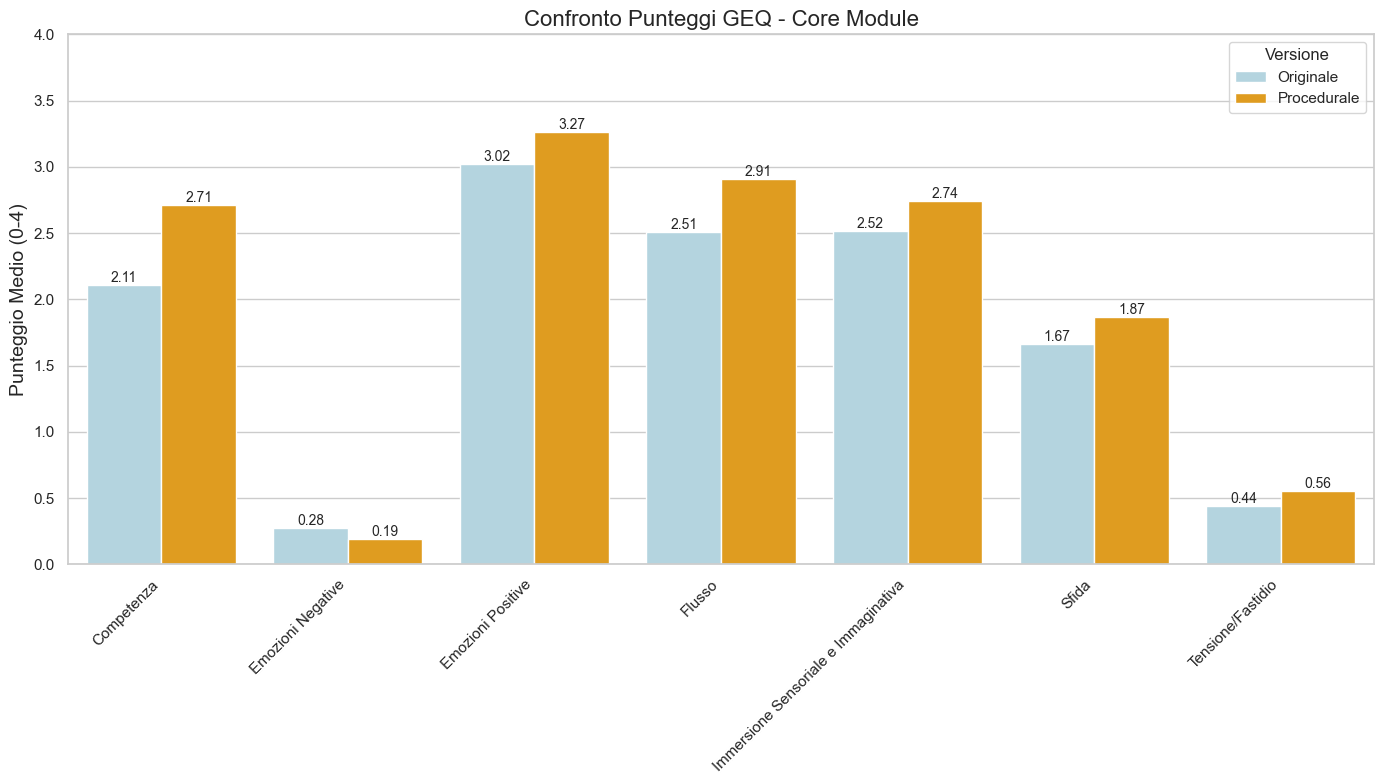

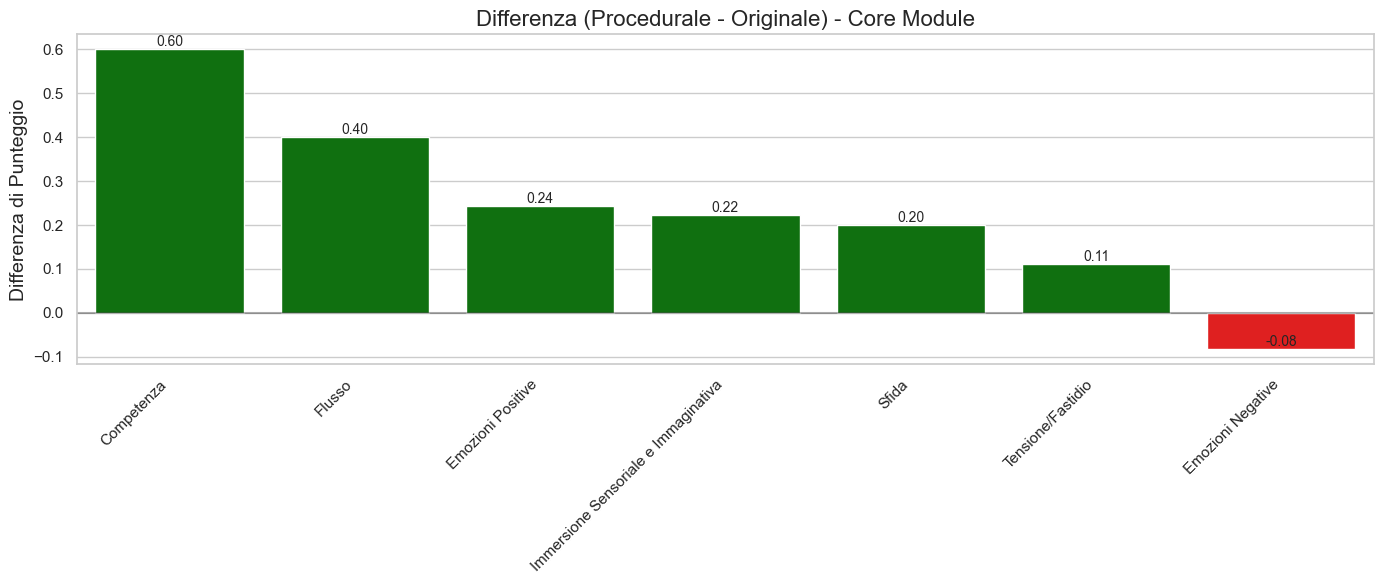

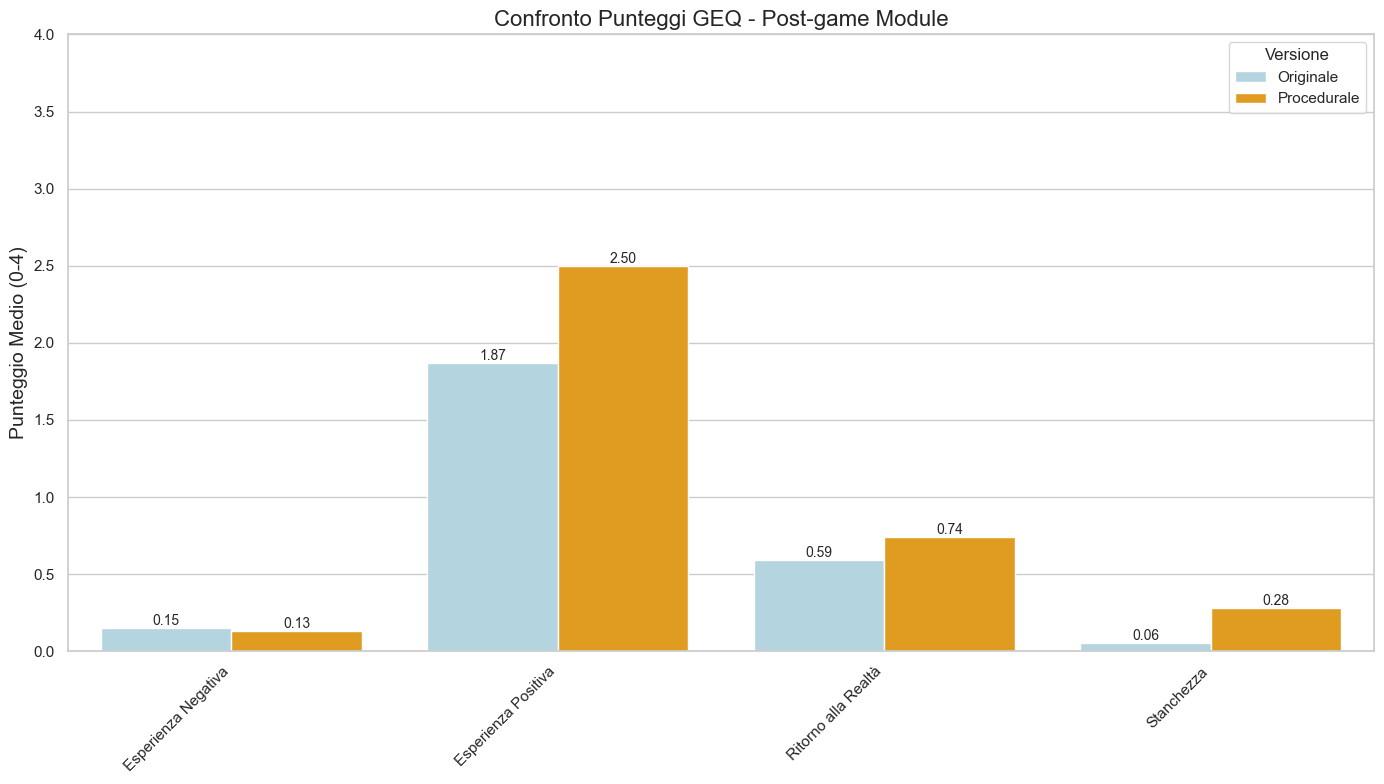

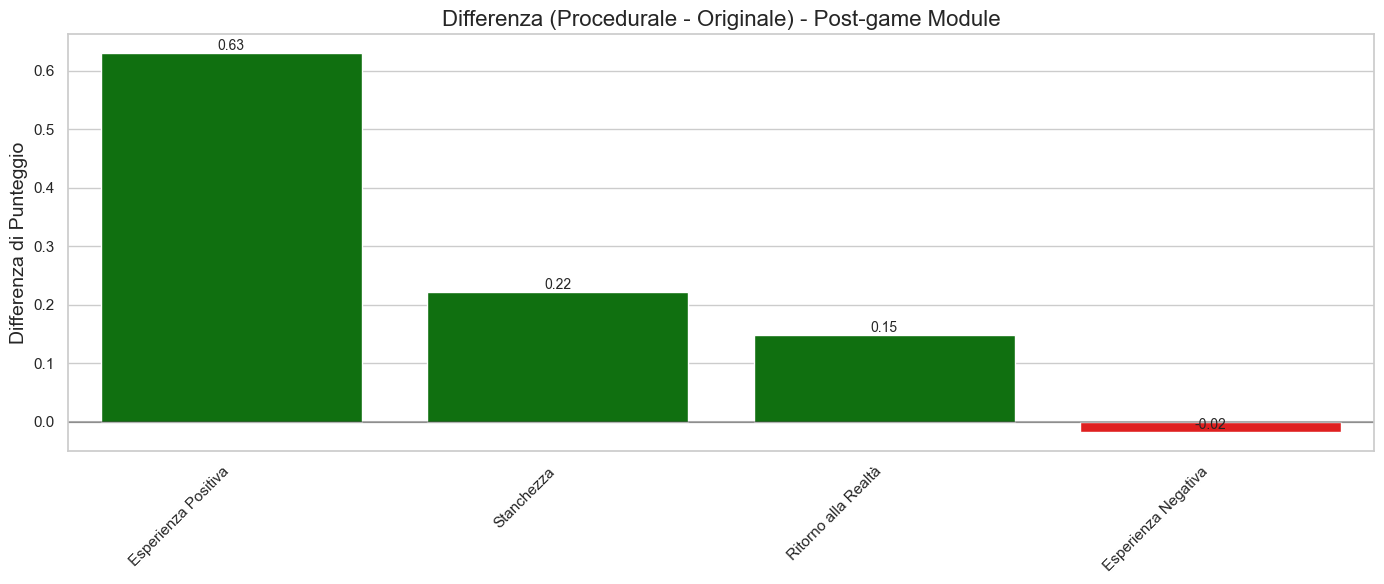

In [40]:
# Per ogni modulo, crea un grafico a barre comparative
for module_name in set(list(results_exam.keys()) + list(results_thesis.keys())):
    # Verifica che entrambi i dataset abbiano dati per questo modulo
    if module_name in results_exam and module_name in results_thesis:
        # Crea un DataFrame combinato per il grafico
        components = set(list(results_exam[module_name].keys()) + list(results_thesis[module_name].keys()))
        data = []
        
        for component in components:
            if component in results_exam[module_name]:
                data.append({
                    'Componente': component,
                    'Punteggio': results_exam[module_name][component],
                    'Versione': 'Originale'
                })
            if component in results_thesis[module_name]:
                data.append({
                    'Componente': component,
                    'Punteggio': results_thesis[module_name][component],
                    'Versione': 'Procedurale'
                })
        
        df_plot = pd.DataFrame(data)
        
        # Ordina il DataFrame per componente
        df_plot = df_plot.sort_values(['Componente', 'Versione'])
        
        plt.figure(figsize=(14, 8))
        # Usa 'Versione' come hue per separare le barre
        ax = sns.barplot(x='Componente', y='Punteggio', hue='Versione', data=df_plot, 
                         palette={'Originale': 'lightblue', 'Procedurale': 'orange'})
        
        plt.title(f'Confronto Punteggi GEQ - {module_name}', fontsize=16)
        plt.ylabel('Punteggio Medio (0-4)', fontsize=14)
        plt.xlabel('')  # Nascondi l'etichetta dell'asse x
        plt.ylim(0, 4)
        
        # Ruota le etichette
        plt.xticks(rotation=45, ha='right')
        
        # Aggiungi valori sopra le barre
        for i, p in enumerate(ax.patches):
            if abs(p.get_height()) > 0.01:
                ax.annotate(f'{p.get_height():.2f}', 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=10, rotation=0)
            
        # Aggiungi una legenda in posizione ottimale
        plt.legend(title='Versione', loc='upper right')
        
        plt.tight_layout()
        plt.show()
        
        # Crea anche un grafico delle differenze
        diff_data = []
        for component in components:
            if component in results_exam[module_name] and component in results_thesis[module_name]:
                diff = results_thesis[module_name][component] - results_exam[module_name][component]
                diff_data.append({
                    'Componente': component,
                    'Differenza': diff,
                    'Direzione': 'Positiva' if diff >= 0 else 'Negativa'  # Aggiungiamo una colonna per il colore
                })
        
        if diff_data:  # Se ci sono differenze da visualizzare
            df_diff = pd.DataFrame(diff_data)
            
            # Ordina per valore assoluto della differenza
            df_diff = df_diff.sort_values('Differenza', key=abs, ascending=False)
            
            plt.figure(figsize=(14, 6))
            # Usa 'Direzione' come hue per determinare i colori
            ax = sns.barplot(x='Componente', y='Differenza', hue='Direzione', data=df_diff, 
                            palette={'Positiva': 'green', 'Negativa': 'red'}, legend=False)
            
            plt.title(f'Differenza (Procedurale - Originale) - {module_name}', fontsize=16)
            plt.ylabel('Differenza di Punteggio', fontsize=14)
            plt.xlabel('')
            plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            
            # Ruota le etichette
            plt.xticks(rotation=45, ha='right')
            
            # Aggiungi valori sopra le barre
            for i, p in enumerate(ax.patches):
                # Ignora annotazioni per valori molto piccoli
                if abs(p.get_height()) > 0.01:  # Puoi regolare questa soglia
                    ax.annotate(f'{p.get_height():.2f}', 
                                (p.get_x() + p.get_width() / 2., p.get_height()), 
                                ha='center', va='bottom', fontsize=10, rotation=0)
            
            plt.tight_layout()
            plt.show()